# Making Data
__This is a brief tutorial on how to generate a data set consisting of boxes using the available tools in this software.__ The various built-in options are explored that allows us to tailor the data set to our requirements.

To begin, we create a folder where we want to save our data.

In [1]:
import os

save = 'data'
if not os.path.exists(save):
    os.mkdir(save)

The prior probability distributions need to be described for the box parameters. _The prior reflects our knowledge of the possible values these parameters can take, before taking measurements._ In this case we define a box as described by 7 parameters: <br>
    - __px, py__ : The location of the centre of the box on the x-y plane. <br>
    - __pz__: The location of the top of the box in the z direction. <br>
    - __lx, ly, lz__: The size of the box in the 3 dimensions, defined in meters. <br>
    - __alpha__: The rotation angle around the z axis. <br>

The built-in prior distibutions are either 'Uniform', defined by lower and upper bounds, or 'Normal', defined by mean and standard deviation.

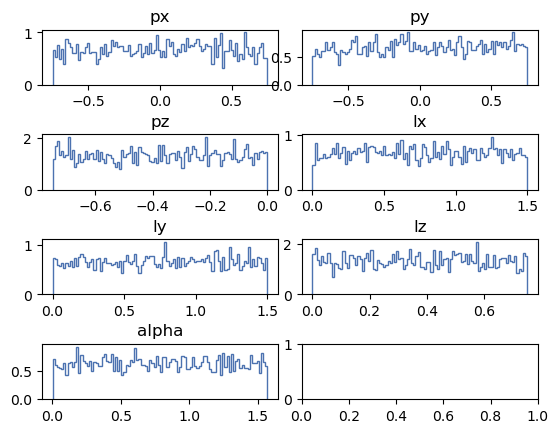

In [2]:
from giflow.prior import Prior

distributions = {
    "px": ['Uniform', -0.75, 0.75],
    "py": ['Uniform', -0.75, 0.75],
    "pz": ['Uniform', -0.75, 0.0], # We do not want the box to extend over the surface!
    "lx": ['Uniform', 0.0, 1.5],
    "ly": ['Uniform', 0.0, 1.5],
    "lz": ['Uniform', 0.0, 0.75],
    "alpha": ['Uniform', 0.0, 1.5708]
}
priors = Prior(distributions=distributions)

priors.plot_distributions()

This Prior object can now be easily sampled from. The next step is to define the configuration of how we define our source models. This can be done using another dictionary with the following options:
- __density__: The relative density within the box wrt. to the background ($kg/m^3$)
- __type__: Can be either voxelised or parameterised. In case of the parameterised configuration, the above parameters are directly used for making the dataset. Otherwise, the voxelised option allows us to translate these parameters into density values on a 3D grid. The rest of the inputs below are only used in case of a voxelised representation.
- __noise_scale__: Can add Gaussian noise to the background of the box to simulate random fluctuations in density. This is read as the standard deviation. ($kg/m^3$) It can be defined by just a single, set value or a distribution similar to the priors.
- __grid_shape__: The list describing the number of voxels in each dimension. The space is didived up equally among these voxels.
- __ranges__: The physical extent of the space that we are defining the voxels in. The rest of space is assumed to have uniform 0 density.

In this case we are making a parameterised data set.

In [3]:
model_framework = {
    "type": 'parameterised',
    "density": -2670.0
}

Once the source models are generated from our prior and defined based on our configuration settings, gravimetry surveys are simulated using an analytical forward model. For this, we need to define our requirements for the simulated surveys, similarly as before. This is again done using a dictionary:
- __survey_shape__: Can be a list of length 1, 2, or 3. If length=1; The survey points are randomly chosen from the specified area on the x-y plane. If length=2; A 2-D grid of points is made on the x-y plane, with the specific number of grid points on each size. If length=3; A 3-D grid of points is made.
- __ranges__: Length has to be 3, where each element defines the minimum and maximum that bound the area in that dimension. [[x mininum, x maximum],[y minimum, y maximum],[z minimum z maximum]]. If the last element has a single value then z is at that set value.
- __noise_scale__: The standard deviation of the instrumental noise. Can be either a single value, or a distribution defined as eg. ['Uniform', lower limit, upper limit]. (_microGal_)
- __noise_on_location_scale__: The standard deviation on the simulated survey locations. Gaussian noise is then added, to simulate an imperfect, more realistic survey grid.

In this case we want to generate surveys on a 2D grid on the z=0 plane. We allow a range of different standard deviations for the noise.

In [4]:
survey_framework = {
    "survey_shape": [8,8],
    "ranges": [[-0.5, 0.5],[-0.5, 0.5],[0.0]],
    "noise_scale": ['Uniform', 0.0, 0.25],
    "noise_on_location_scale": 0.0
}

Now we can construct our data set and save it to a desired file.

In [5]:
import pickle as pkl
from giflow.box import BoxDataset

size = 5000 # Only making a small batch here, in reality we will likely need more data than this.
dt_train = BoxDataset(
    priors = priors,
    size = size,
    survey_framework = survey_framework,
    model_framework = model_framework
)
dt_train.make_dataset()

filename = os.path.join(save, 'trainset.pkl')
with open(filename, 'wb') as file:
    pkl.dump(dt_train, file)

0/5000 data points made
1000/5000 data points made
2000/5000 data points made
3000/5000 data points made
4000/5000 data points made


Validation and simualted test data can be generated the same way. It is also an option to create a data set with pre-set parameters, instead of randomly drawing from the prior, by passing the _parameters_dict_ argument to the _make_dataset()_ function.

In [8]:
# Validation data
size = 500
dt_val = BoxDataset(
    priors = priors,
    size = size,
    survey_framework = survey_framework,
    model_framework = model_framework
)
dt_val.make_dataset()

filename = os.path.join(save, 'valset.pkl')
with open(filename, 'wb') as file:
    pkl.dump(dt_val, file)

0/500 data points made


In [10]:
import numpy as np

size = 2
dt_test = BoxDataset(
    priors = priors,
    size = size,
    survey_framework = survey_framework,
    model_framework = model_framework
)
parameters_dict = dict.fromkeys(priors.keys)
parameters_dict['px'] = np.array([0.0, 0.5])
parameters_dict['py'] = np.array([0.5, -0.5])
parameters_dict['pz'] = np.array([-0.25, -0.5])
parameters_dict['lx'] = np.array([0.5, 1.0])
parameters_dict['ly'] = np.array([0.5, 1.0])
parameters_dict['lz'] = np.array([0.1, 0.5])
parameters_dict['alpha'] = np.array([0.0, 1.0])

dt_test.make_dataset(parameters_dict = parameters_dict)

filename = os.path.join(save, 'testset.pkl')
with open(filename, 'wb') as file:
    pkl.dump(dt_test, file)

0/2 data points made
